In [283]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [170]:
# load 50k real images from Pythia
real_jets = np.load('/home/lukedeo/scratch/data/gan/jetimages.npy', mmap_mode='r')
ix = range(real_jets.shape[0])
np.random.shuffle(ix)
real_jets = np.array(real_jets[ix][:50000])

In [171]:
real_images = real_jets['image']
real_labels = real_jets['signal']

In [4]:
cd v4-great-dispersion/

/home/micky/GAN/adversarial-jets/models/v4-great-dispersion


In [172]:
from generators import locally_connected_generator as build_generator

In [173]:
# g = build_generator(256)
g, (z, image_class), (cnn_img, fcn_img) = build_generator(256, return_intermediate=True)

In [174]:
from keras.models import model_from_json, Model
cnn_model = Model(input=[z, image_class], output=cnn_img)
fcn_model = Model(input=[z, image_class], output=fcn_img)

In [8]:
#fname = '/home/lukedeo/jet-gan-256.h5'

In [175]:
fname = sorted(glob('params_generator*'))[-12]

In [55]:
#fname = '/home/lukedeo/great-gan-256.h5'

In [56]:
#from keras.models import model_from_json, Model

In [100]:
#g = model_from_json(open('/home/lukedeo/great-gan-256.json').read(), custom_objects={'ConstrainedReLU': ConstrainedReLU})

In [ ]:
#g.load_weights(fname)

In [176]:
g.load_weights(fname)

In [177]:
# create some random noise and request some specific labels
noise = np.random.normal(0, 1, (50000, 256))
sampled_labels = np.random.randint(0, 2, 50000)

In [178]:
# get a batch to display
generated_images = g.predict(
    [noise, sampled_labels.reshape(-1, 1)], verbose=True, batch_size=128)
generated_images_from_branch0 = cnn_model.predict(
    [noise, sampled_labels.reshape(-1, 1)], verbose=True, batch_size=128)
generated_images_from_branch1 = fcn_model.predict(
    [noise, sampled_labels.reshape(-1, 1)], verbose=True, batch_size=128)

49792/50000 [============================>.] - ETA: 0s

In [179]:
from discriminators import two_channel_discriminator as build_discriminator

In [180]:
# -- check the quality of the generated images
# -- do they fool the discriminator? (isreal > 0.5?)
# -- we should probably only consider those that do and discard those that don't
d = build_discriminator()
#b.load_weights('./v6_weights_discriminator.hdf5')
d.load_weights(sorted(glob('params_discriminator*'))[-12])
# WHAT'S THE RIGHT SET OF WEIGHTS TO LOAD??

In [181]:
disreal, aux_out = np.array(d.predict(generated_images, verbose=True, batch_size=100))
isreal_pythia, aux_out_pythia = np.array(d.predict(np.expand_dims(real_images / 100, -1), verbose=True, batch_size=100))

50000/50000 [==============================] - 4s     


In [182]:
print '{}% of generated images look real.'.format(100*sum(isreal >= 0.5)[0] / float(len(isreal)))
print '{}% of Pythia images look real.'.format(100*sum(isreal_pythia >= 0.5)[0] / float(len(isreal_pythia)))

29.894% of generated images look real.
77.65% of Pythia images look real.


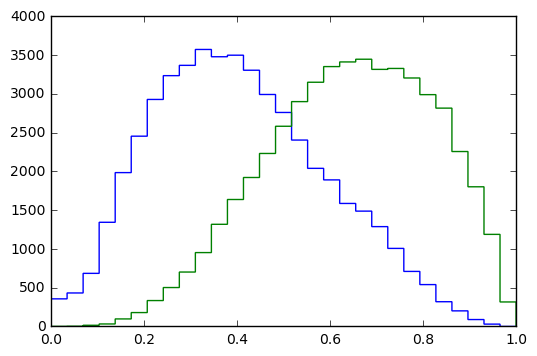

In [183]:
bins = np.linspace(0, 1, 30)
_ = plt.hist(isreal, bins=bins, histtype='step', label='GAN')
_ = plt.hist(isreal_pythia, bins=bins, histtype='step', label='Pythia')
#plt.yscale('log')
# note: the D seems to be pretty certain about its predictions (close to 0 and 1) even if they are wrong
# why is it so willing to say that images are fake?
# should we encourage it to predict 'real' more often?

In [184]:
generated_images = (generated_images) * 100 # because they were previously divided by 100
generated_images_from_branch0 = (generated_images_from_branch0) * 100 # because they were previously divided by 100
generated_images_from_branch1 = (generated_images_from_branch1) * 100 # because they were previously divided by 100

In [108]:
# transform (None, 25, 25, 1) => (None, 25, 25)
generated_images = np.squeeze(generated_images)
generated_images_from_branch0 = np.squeeze(generated_images_from_branch0)
generated_images_from_branch1 = np.squeeze(generated_images_from_branch1)

In [56]:
# save some images out for later analysis
#np.save('/home/micky/scratch/data/gan/gan-images.npy', generated_images)

In [57]:
np.argwhere(isreal.reshape(-1,) > 0.5)

array([[    1],
       [    5],
       [   16],
       ..., 
       [49962],
       [49988],
       [49999]])

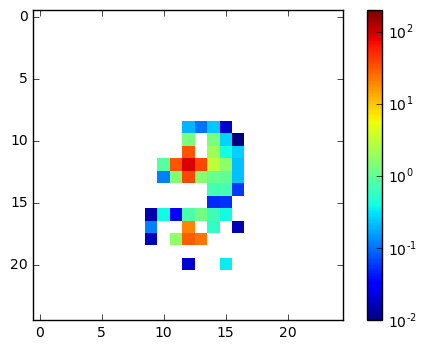

In [109]:
# -- display one single random generated image that was labeled as real
im = generated_images[1]
plt.imshow(im, interpolation='nearest', norm=LogNorm(vmin=1e-2, vmax=200))
plt.colorbar()

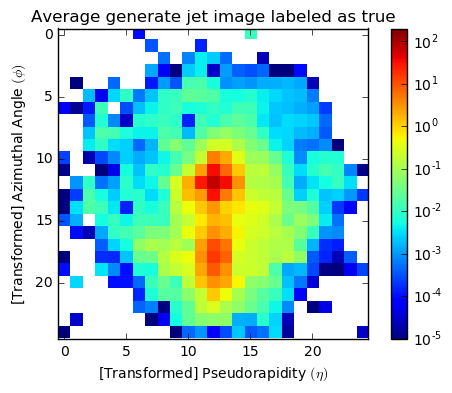

In [110]:
# -- average generated image that fools the D
plt.imshow(generated_images[isreal.reshape(-1,) > 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average generate jet image labeled as true')

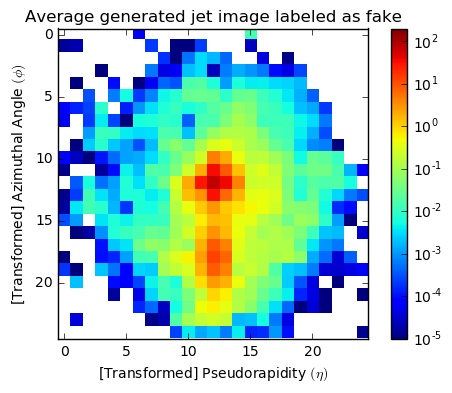

In [111]:
# -- average generated image that does not fool the D
plt.imshow(generated_images[isreal.reshape(-1,) < 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average generated jet image labeled as fake')

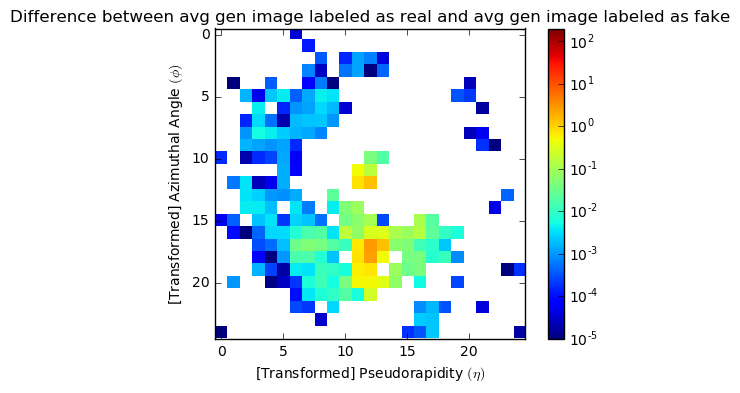

In [112]:
# -- difference between the average image that fools the D and the avg image that doesn't
plt.imshow(generated_images[isreal.reshape(-1,) > 0.5].mean(axis=0) - generated_images[isreal.reshape(-1,) < 0.5].mean(axis=0),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference between avg gen image labeled as real and avg gen image labeled as fake')

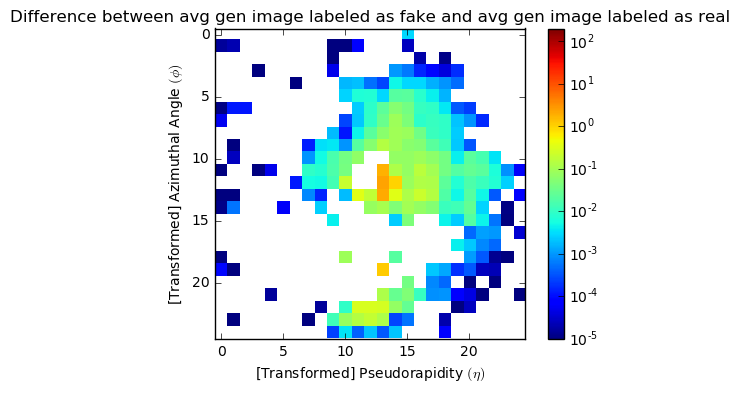

In [113]:
# -- difference between the average image labeled as fake and image labeled as real
plt.imshow(generated_images[isreal.reshape(-1,) < 0.5].mean(axis=0) - generated_images[isreal.reshape(-1,) > 0.5].mean(axis=0),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference between avg gen image labeled as fake and avg gen image labeled as real')

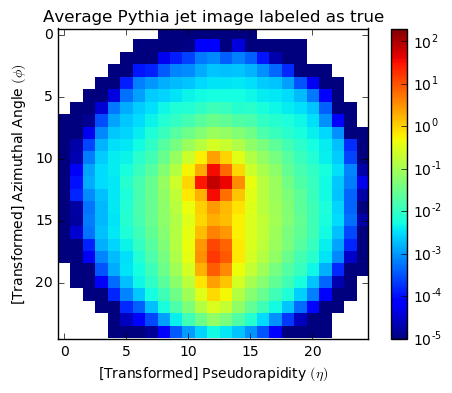

In [114]:
# -- average Pythia image that the D correctly labels as real
plt.imshow(real_images[isreal_pythia.reshape(-1,) > 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia jet image labeled as true')

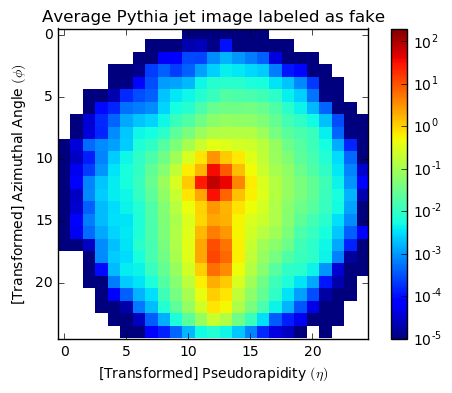

In [115]:
# -- average Pythia image that the D thinks is fake
plt.imshow(real_images[isreal_pythia.reshape(-1,) < 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia jet image labeled as fake')

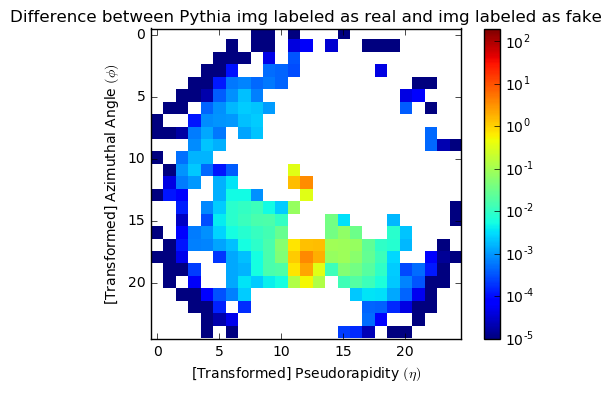

In [116]:
# -- average Pythia image that the D thinks is fake
plt.imshow(real_images[isreal_pythia.reshape(-1,) > 0.5].mean(axis=0) - real_images[isreal_pythia.reshape(-1,) < 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference between Pythia img labeled as real and img labeled as fake')

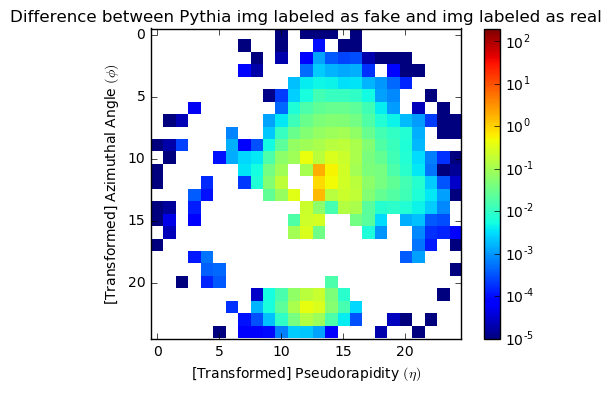

In [117]:
# -- average Pythia image that the D thinks is fake
plt.imshow(real_images[isreal_pythia.reshape(-1,) < 0.5].mean(axis=0) - real_images[isreal_pythia.reshape(-1,) > 0.5].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference between Pythia img labeled as fake and img labeled as real')

## NOTE:
Just by visual inspection, it looks like, on average, images that are more concentrated in the center are more often labelled as fake, while images that are more spread out look more convincingly real.

We can make sense of this by thinking about the fact that the average Pythia image has that nice ring of low energy depositions that expands all the way out to the borders of the image, while the average generate image lacks this property and tends to be more concentrated around the energetic part of the image. Therefore, the Discriminator seems to learn that more spread out images are more likely to be real, and more concentrated images are more likely to be fake.

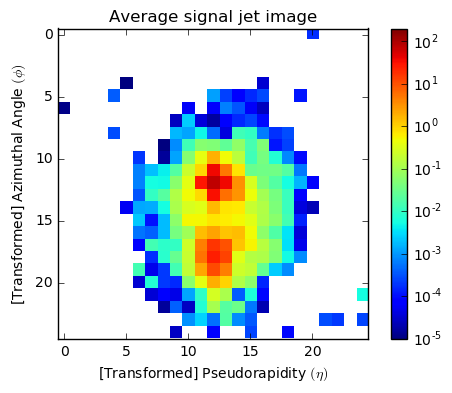

In [33]:
# -- average generated signal image
plt.imshow(generated_images[sampled_labels == 1].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image')

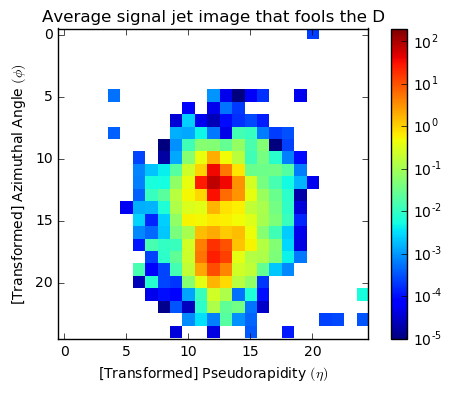

In [34]:
# -- average generated signal image that passes the D
plt.imshow(generated_images[(sampled_labels == 1) & (isreal.reshape(-1,) > 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image that fools the D')

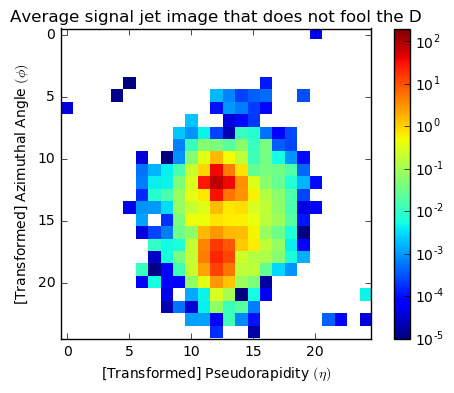

In [35]:
# -- average generated signal image that doesn't pass the D
plt.imshow(generated_images[(sampled_labels == 1) & (isreal.reshape(-1,) < 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average signal jet image that does not fool the D')

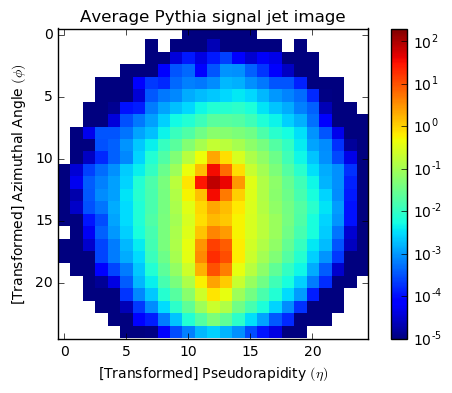

In [36]:
# -- average Pythia signal image
plt.imshow(real_images[(real_labels == 1)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia signal jet image')

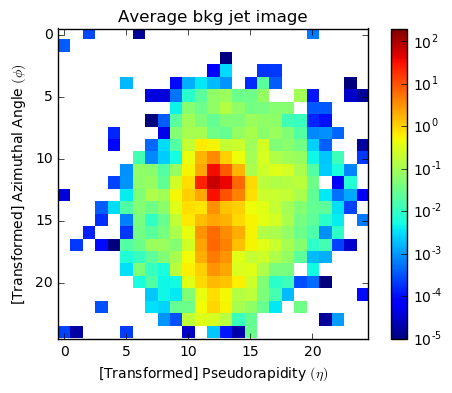

In [37]:
# -- average generated bkg image
plt.imshow(generated_images[sampled_labels == 0].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image')

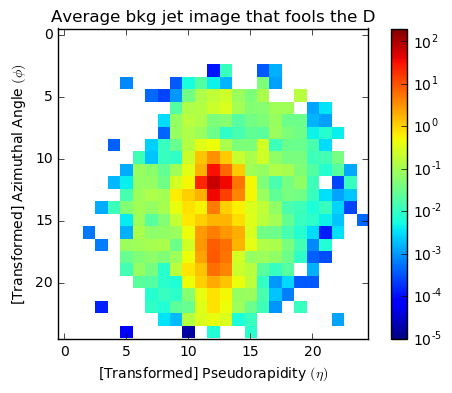

In [38]:
# -- average generated bkg image that fools the D
plt.imshow(generated_images[(sampled_labels == 0) & (isreal.reshape(-1,) > 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image that fools the D')

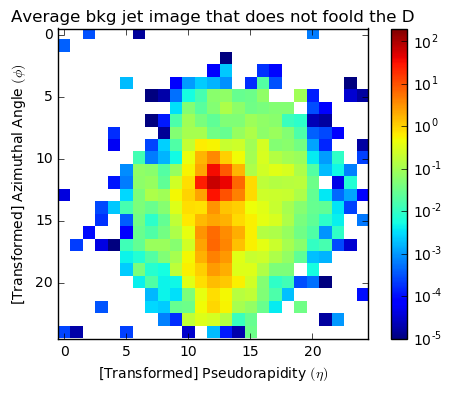

In [39]:
# -- average generated bkg image that doesn't fool the D
plt.imshow(generated_images[(sampled_labels == 0) & (isreal.reshape(-1,) < 0.5)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average bkg jet image that does not foold the D')

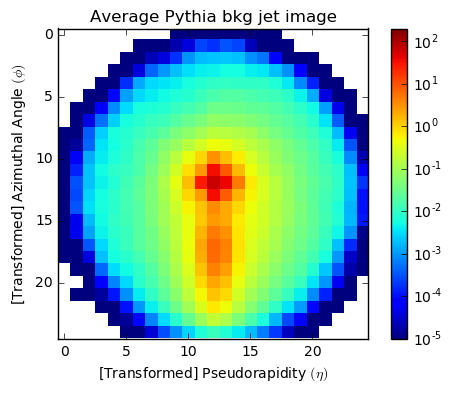

In [40]:
# -- average Pythia bkg image
plt.imshow(real_images[(real_labels == 0)].mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average Pythia bkg jet image')

# What are the different branches of the Generator focusing on?

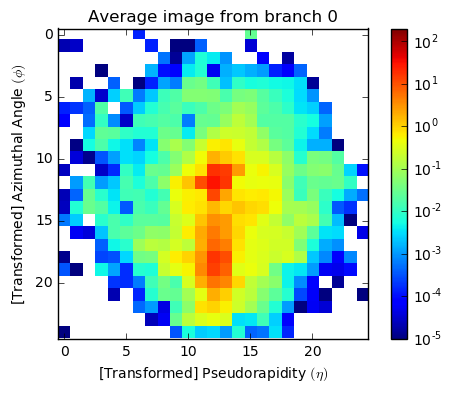

In [118]:
# -- what's being learned by one branch of the G (CNN)
plt.imshow(generated_images_from_branch0.mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average image from branch 0')

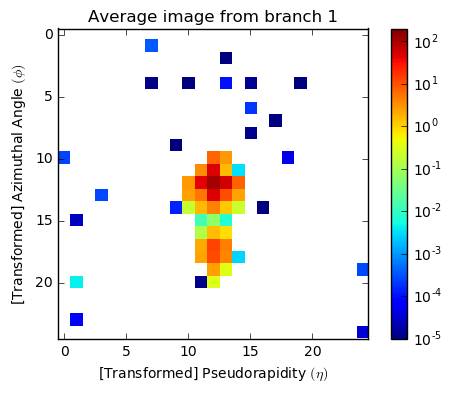

In [119]:
# -- what's being learned by the other branch of the G (FCN)
plt.imshow(generated_images_from_branch1.mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Average image from branch 1')

In [56]:
from keras.utils.visualize_util import plot as modelplot

In [61]:
modelplot(g.layers[-3], 'genCNN.png', show_shapes=True)

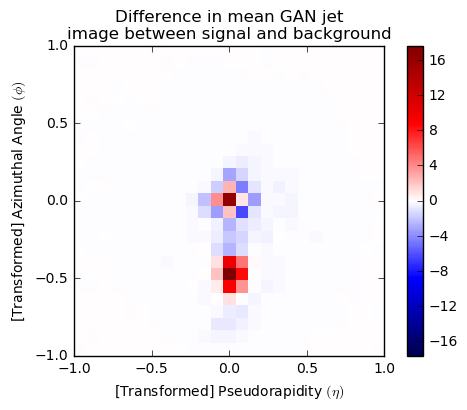

In [120]:
# -- plot difference between mean signal and mean bkg for GAN generated images
diff = generated_images[sampled_labels == 1].mean(axis=0) - generated_images[sampled_labels == 0].mean(axis=0)
lim = np.max(np.abs(diff))
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean GAN jet\nimage between signal and background')
plt.colorbar()

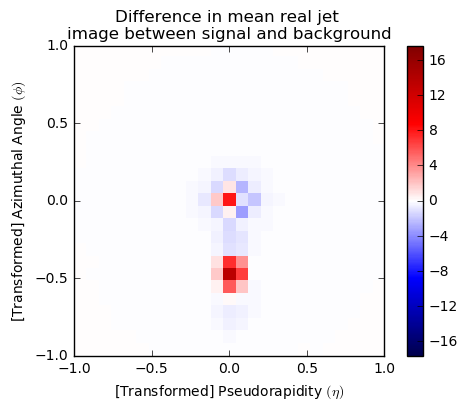

In [121]:
# -- plot difference between mean signal and mean bkg for real images
diff = real_images[real_labels == 1].mean(axis=0) - real_images[real_labels == 0].mean(axis=0)
plt.imshow(diff, interpolation='nearest', cmap=cm.seismic, vmax=lim, vmin=-lim, extent=[-1, 1, -1, 1])
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Difference in mean real jet \nimage between signal and background')
plt.colorbar()

In [122]:
# form the grids you need to represent the eta, phi coordinates
grid = 0.5 * (np.linspace(-1, 1, 26)[:-1] + np.linspace(-1, 1, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

In [551]:
def discrete_mass(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    return np.sqrt(np.square(Px) + np.square(Py))

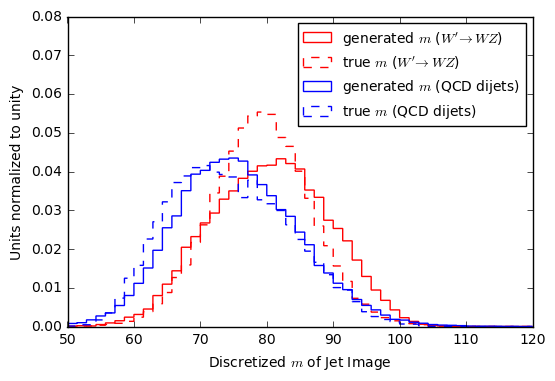

In [124]:
# plot the mass of the GAN vs the Pythia Jets
bins = np.linspace(50, 120, 50)
_ = plt.hist(discrete_mass(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $m$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $m$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_mass(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $m$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_mass(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $m$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(prop={'size':10})
plt.ylim(0, 0.08)
plt.show()

[]

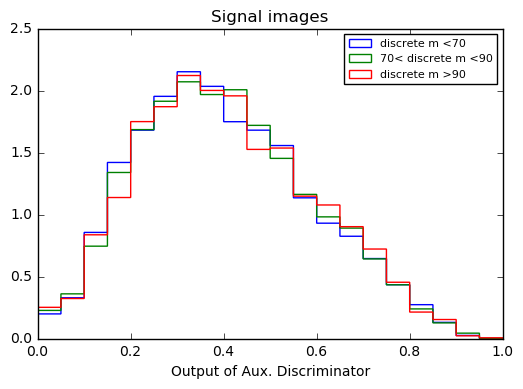

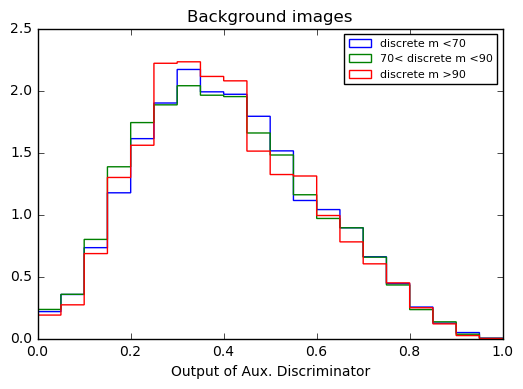

In [125]:
# Do generated images in different mass ranges get labeled as real/fake more often than others?
bins = np.linspace(0, 1, 21)
f = plt.figure()
_ = plt.hist(isreal[discrete_mass(generated_images[sampled_labels == 1]) < 70],
            bins=bins, histtype='step', label='discrete m <70', normed=True)
_ = plt.hist(isreal[
                (discrete_mass(generated_images[sampled_labels == 1]) > 70) &
                (discrete_mass(generated_images[sampled_labels == 1]) < 90)],
            bins=bins, histtype='step', label='70< discrete m <90', normed=True)
_ = plt.hist(isreal[discrete_mass(generated_images[sampled_labels == 1]) > 90],
            bins=bins, histtype='step', label='discrete m >90', normed=True)
plt.title('Signal images')
plt.xlabel('Output of Aux. Discriminator')
plt.legend(fontsize=8)
plt.plot()

f = plt.figure()
_ = plt.hist(isreal[discrete_mass(generated_images[sampled_labels == 0]) < 70],
            bins=bins, histtype='step', label='discrete m <70', normed=True)
_ = plt.hist(isreal[
                (discrete_mass(generated_images[sampled_labels == 0]) > 70) &
                (discrete_mass(generated_images[sampled_labels == 0]) < 90)],
            bins=bins, histtype='step', label='70< discrete m <90', normed=True)
_ = plt.hist(isreal[discrete_mass(generated_images[sampled_labels == 0]) > 90],
            bins=bins, histtype='step', label='discrete m >90', normed=True)
plt.title('Background images')
plt.xlabel('Output of Aux. Discriminator')
plt.legend(fontsize=8)
plt.plot()
# --> hard to say much about whether the D is forcing images to be generated in a certain mass range...

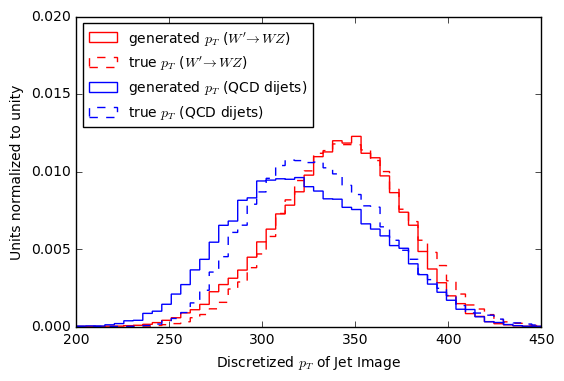

In [126]:
# plot the pT of the GAN vs the Pythia Jets
bins = np.linspace(200, 450, 50)
_ = plt.hist(discrete_pt(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_pt(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"true $p_T$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_pt(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated $p_T$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_pt(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'true $p_T$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')
plt.xlabel(r'Discretized $p_T$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(loc=2, prop={'size':10})
plt.ylim(0, 0.02)
plt.show()

In [127]:
print real_images.ravel().shape, generated_images.ravel().shape

(31250000,) (31250000,)


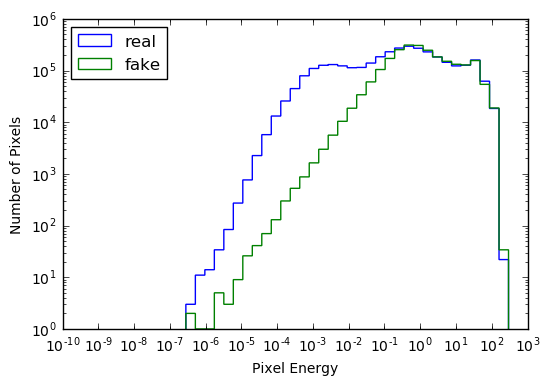

In [128]:
_, bins, _ = plt.hist(real_images.ravel(), 
                      bins=np.logspace(-10, 3, 50), histtype='step', label='real')
#_, bins, _ = plt.hist(real_images.ravel(), 
#            bins=np.linspace(0, 500, 50), log=True, histtype='step', normed=True, label='real')
_ = plt.hist(generated_images.ravel(), 
             bins=bins, histtype='step', label='fake')
plt.xscale('log')
plt.xlabel('Pixel Energy')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper left')
# -- generated images are more sparse than the real ones, on average 

In [ ]:
#np.save('/home/lukedeo/scratch/data/gan/slim.npy', real_jets)

In [129]:
print 'percentage of pixels in the real images that are empty = {}%'.format(
    100 * float((real_images.ravel() == 0).sum()) / len(real_images.ravel())
)

percentage of pixels in the real images that are empty = 89.3086464%


In [130]:
print 'percentage of pixels in the generated images that are empty = {}%'.format(
    100 * float((generated_images.ravel() == 0).sum()) / len(generated_images.ravel())
)

percentage of pixels in the generated images that are empty = 92.4473472%


Again, this shows that real images have more active pixels than generated images

# Calculate mass and nsubj

In [50]:
from mass import image_mass_func

In [51]:
jet_mass = image_mass_func(eta, phi, use_keras=False)

In [75]:
jet_mass(np.expand_dims(real_images, 1))

array([ 78.86623897,  80.16181017,  54.82688725, ...,  88.56439669,
        69.68403178,  74.39933881])

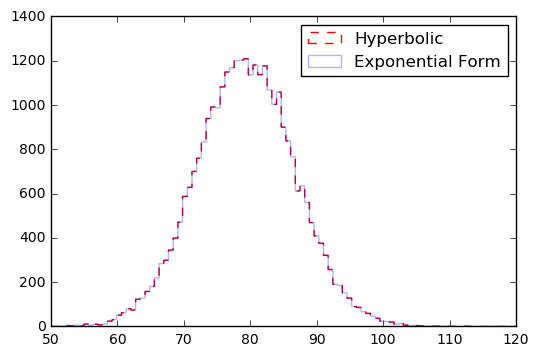

In [76]:
bins = np.linspace(50, 120, 100)
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label='Hyperbolic', color='red', linestyle='dashed')
_ = plt.hist(jet_mass(np.expand_dims(real_images[real_labels == 1], 1)), 
             bins=bins, histtype='step', label='Exponential Form', alpha=0.3)
plt.legend()
# matches perfectly ✓

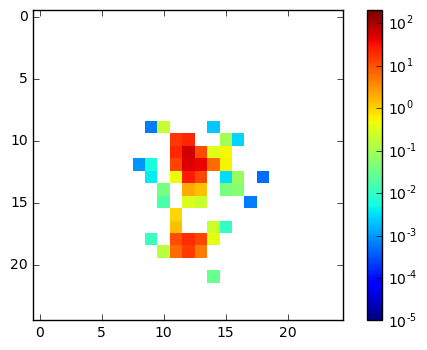

In [131]:
plt.imshow(real_images[0], interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()

In [ ]:
# while (len(proto_jet_eatas) > 2): #should start as the number of pixels, which is hopefully bigger than two :)
#   loop over pairs of pixels
#      find the pair with the smallest value of min(pT1^2,pT2^2)*((eta_1-eta_2)^2+(phi_1-phi_2)^2) #be careful here about delta phi!  i.e. 2\pi-0 is close to zero and not close to 2pi!
#      # ^^ that is not zero? or should I start with all the ones that are zero and remove them?     
#      for this pair, remove their eta, phi, pT from the list and add back (‘winner-takes-all’):
#      eta_add =  pixel_pT_1/cosh(pixel_eta_1) > pixel_pT_2/cosh(pixel_eta_2) ? pixel_eta_1 : pixel_eta_2  #i.e. take the position of the higher energy of the two 
#      phi_add =  pixel_pT_1/cosh(pixel_eta_1) > pixel_pT_2/cosh(pixel_eta_2) ? pixel_phi_1 : pixel_phi_2  #i.e. take the position of the higher energy of the two 
#      proto_jet_eatas+= [ eta_add ]
#      proto_jet_phis += [ phi_add ]
#      proto_jet_pTs += [ (pixel_pT_1/cosh(pixel_eta_1) +  pixel_pT_2/cosh(pixel_eta_2))*cosh(eta_add) ] #energies add and resulting object is massless.

# tau2 = sum over pixels of pT * min { ((proto_jet_eatas[0]-pixel_eta)**2+(proto_jet_phis[o]-pixel_phi)**2)**0.5 , ((proto_jet_eatas[1]-pixel_eta)**2+(proto_jet_phis[1]-pixel_phi)**2)**0.5 }  #be careful here about delta phi!  i.e. 2\pi-0 is close to zero and not close to 2pi!

# return tau1 > 0 ? tau2/tau1 : 0

In [132]:
import math
def dphi(phi1, phi2): 
        return math.acos(math.cos(abs(phi1 - phi2)))

In [133]:
def _tau1(jet_image):
    # -- calculate tau1 
    # find coordinate of most energetic pixel, then use formula to compute tau1
    tau1_axis_eta = eta.ravel()[np.argmax(jet_image)]
    tau1_axis_phi = phi.ravel()[np.argmax(jet_image)]
    tau1 = np.sum(jet_image * 
            np.sqrt(np.square(tau1_axis_eta - eta) + np.square([dphi(tau1_axis_phi, p) for p in phi.ravel()]).reshape(25, 25))
                 ) 
#     tau1 = np.sum( jet_image * 
#             np.sqrt(np.square(tau1_axis_eta - eta) + np.square(tau1_axis_phi - phi))
#                  ) 
    return tau1 / np.sum(jet_image)

# def _tau2(jet_image):
#     # -- calculate tau2
#     # do not include empty pixels in the calculation
#     proto_jet_etas =  eta[jet_image != 0]
#     proto_jet_phis = phi[jet_image != 0]
#     proto_jet_pts = jet_image[jet_image != 0]

#     # -- iterate until we are left with only 2 pixels
#     while (len(proto_jet_etas) > 2):
#         # -- form all combinations of indices of cells
#         couples = []
#         arr = range(len(proto_jet_etas))
#         for i in arr:
#             couples.extend(zip([arr[i]]*len(arr[i+1:]), arr[i+1:]))

#         val = []
#         for c in couples:
#             val.append(
#                 min(proto_jet_pts[c[0]]**2, proto_jet_pts[c[1]]**2) * (
#                 (proto_jet_etas[c[0]] - proto_jet_etas[c[1]])**2 + (dphi(proto_jet_phis[c[0]], proto_jet_phis[c[1]]))**2)
#             )
#         idx_min = list(couples[np.argmin(val)])
#         eta_min = proto_jet_etas[idx_min]
#         phi_min = proto_jet_phis[idx_min]
#         pt_min = proto_jet_pts[idx_min]

#         if pt_min[0]/np.cosh(eta_min[0]) > pt_min[1]/np.cosh(eta_min[1]):
#         #if pt_min[0] > pt_min[1]:
#             proto_jet_etas = np.append(proto_jet_etas, eta_min[0])
#             proto_jet_phis = np.append(proto_jet_phis, phi_min[0])
#         else:
#             proto_jet_etas = np.append(proto_jet_etas, eta_min[1])
#             proto_jet_phis = np.append(proto_jet_phis, phi_min[1])

#         proto_jet_pts = np.append(
#                             proto_jet_pts, 
#                                   np.cosh(proto_jet_etas[-1]) * (
#                                     pt_min[0]/np.cosh(eta_min[0]) +
#                                     pt_min[1]/np.cosh(eta_min[1])
#                                   )
#                             )

#         proto_jet_etas = np.delete(proto_jet_etas, idx_min)
#         proto_jet_phis = np.delete(proto_jet_phis, idx_min)
#         proto_jet_pts = np.delete(proto_jet_pts, idx_min)

#     tau2 = np.sum(jet_image * np.array(
#         [min(i) for i in zip(
#             np.sqrt(np.square(eta.ravel() - proto_jet_etas[0]) + np.square([dphi(p, proto_jet_phis[0]) for p in phi.ravel()])), 
#             np.sqrt(np.square(eta.ravel() - proto_jet_etas[1]) + np.square([dphi(p, proto_jet_phis[1]) for p in phi.ravel()]))
#          )]
#     ).reshape(25,25))
    
#     return tau2 / np.sum(jet_image)

def _tau2(jet_image):
    proto = np.array(zip(jet_image[jet_image != 0],
                         eta[jet_image != 0],
                         phi[jet_image != 0]))

    while len(proto) > 2:
        candidates = [
            (
                (i, j),
                (min(pt1, pt2) ** 2) * ((eta1 - eta2) ** 2 + (phi1 - phi2) ** 2)
            )
            for i, (pt1, eta1, phi1) in enumerate(proto)
            for j, (pt2, eta2, phi2) in enumerate(proto)
            if j > i
        ]

        index, value = zip(*candidates)
        pix1, pix2 = index[np.argmin(value)]
        if pix1 > pix2:
            # swap
            pix1, pix2 = pix2, pix1

        (pt1, eta1, phi1) = proto[pix1]
        (pt2, eta2, phi2) = proto[pix2]

        e1 = pt1 / np.cosh(eta1)
        e2 = pt2 / np.cosh(eta2)
        choice = e1 > e2

        eta_add = (eta1 if choice else eta2)
        phi_add = (phi1 if choice else phi2)
        pt_add = (e1 + e2) * np.cosh(eta_add)

        proto[pix1] = (pt_add, eta_add, phi_add)

        proto = np.delete(proto, pix2, axis=0).tolist()

    (_, eta1, phi1), (_, eta2, phi2) = proto
    np.sqrt(np.square(eta - eta1) + np.square(phi - phi1))

    grid = np.array([
        np.sqrt(np.square(eta - eta1) + np.square(phi - phi1)),
        np.sqrt(np.square(eta - eta2) + np.square(phi - phi2))
    ]).min(axis=0)

    return np.sum(jet_image * grid) / np.sum(jet_image)

def tau21(jet_image):
    tau1 = _tau1(jet_image)
    if tau1 <= 0:
        return 0
    else:
        tau2 = _tau2(jet_image)
        return tau2 / tau1

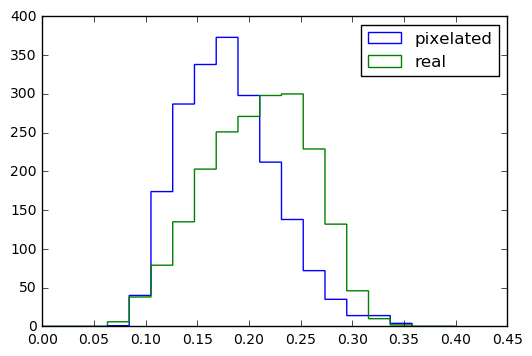

In [134]:
pixelated_tau1 =  [_tau1(img) for img in real_images[:2000]]
bins = np.linspace(0, 0.4, 20)
_ = plt.hist(pixelated_tau1, bins=bins, histtype='step', label='pixelated')
_ = plt.hist(real_jets['tau_1'][:2000], bins=bins, histtype='step', label='real')
plt.legend()

In [135]:
zip(real_jets['tau_1'][:20], [_tau1(img) for img in real_images[:20]])

[(0.19263032, 0.19096935275086868),
 (0.19973025, 0.16545162490009674),
 (0.13819377, 0.12137181648232942),
 (0.17092545, 0.14952559960115266),
 (0.20628326, 0.17148538600240917),
 (0.24211706, 0.19327066835375606),
 (0.17693242, 0.14616377213303597),
 (0.18492308, 0.15703816332768741),
 (0.21829996, 0.19192105688404823),
 (0.16796972, 0.14960850985007443),
 (0.25734678, 0.22286771832675614),
 (0.16442433, 0.14118017611669956),
 (0.26457843, 0.21371963607911615),
 (0.2859211, 0.21577005472295882),
 (0.26679972, 0.25588958681309149),
 (0.13722764, 0.1298619635779539),
 (0.23743227, 0.20668052920724378),
 (0.24662343, 0.20610351351087733),
 (0.24803372, 0.20679614017960751),
 (0.23604392, 0.20763105901906162)]

In [136]:
zip(real_jets['tau_2'][:20], [_tau2(img) for img in real_images[:20]])

[(0.08018215, 0.083331954709023423),
 (0.020183571, 0.051259685708981817),
 (0.01814452, 0.052351136722067197),
 (0.072199717, 0.086699344250494526),
 (0.093790606, 0.091376028535162371),
 (0.15611497, 0.14071029893127585),
 (0.13563116, 0.11771566032169119),
 (0.094996721, 0.086565868707731697),
 (0.065833777, 0.072910059005633493),
 (0.007261551, 0.05133754955688969),
 (0.16108193, 0.14346095706209303),
 (0.02832216, 0.059154262627044353),
 (0.046312064, 0.068949086890805797),
 (0.086049013, 0.086212558767546063),
 (0.055463899, 0.071215358306104523),
 (0.046992879, 0.059303774807335202),
 (0.097611092, 0.089704542160151252),
 (0.1078264, 0.095253798695859176),
 (0.023761578, 0.056887135201540123),
 (0.028767614, 0.058831053805030932)]

In [137]:
from tqdm import tqdm

In [138]:
zip(real_jets['tau_21'][:40], [tau21(img) for img in real_images[:40]])

[(0.41624886, 0.43636297399894897),
 (0.10105415, 0.3098167560453608),
 (0.13129766, 0.43132860856283733),
 (0.42240471, 0.57982943711149093),
 (0.45466903, 0.53285023677690324),
 (0.64479125, 0.72804787260177783),
 (0.76657039, 0.80536824278555319),
 (0.51370937, 0.55124096508373555),
 (0.30157486, 0.37989608951394593),
 (0.043231308, 0.34314591869363609),
 (0.62593335, 0.64370451736647938),
 (0.17225042, 0.41899836261818679),
 (0.17504096, 0.32261465607812362),
 (0.30095372, 0.39955757010971688),
 (0.20788589, 0.27830502676188268),
 (0.34244472, 0.45666778149196985),
 (0.4111113, 0.43402512323839776),
 (0.43721071, 0.46216484655334156),
 (0.095799789, 0.27508799319045441),
 (0.12187399, 0.28334418792147054),
 (0.1669208, 0.34630427018062238),
 (0.57043982, 0.63763580877921866),
 (0.24691981, 0.33570399595480427),
 (0.27783501, 0.33176127236599706),
 (0.38662872, 0.51332630106341026),
 (0.40059289, 0.48045769752568496),
 (0.69151759, 0.6382528508512445),
 (0.13681528, 0.31771048458018

In [ ]:
pixelated_tau21 =  [tau21(img) for img in tqdm(real_images[:2000])]

In [143]:
pixelated_tau21_gan =  [tau21(img) for img in tqdm(generated_images[:2000])]

100%|██████████| 2000/2000 [01:00<00:00, 36.23it/s]


100%|██████████| 2000/2000 [02:28<00:00, 13.44it/s]


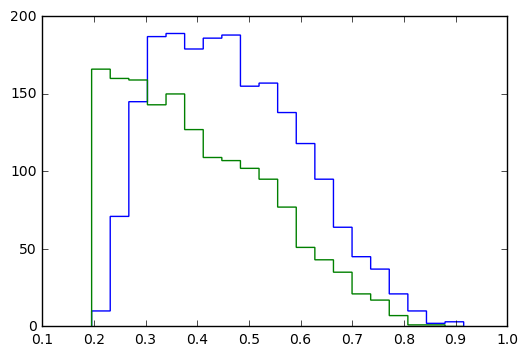

In [141]:
_, b, _ = plt.hist(pixelated_tau21, bins=20, histtype='step')
_ = plt.hist(real_jets['tau_21'][:2000], bins=b, histtype='step')

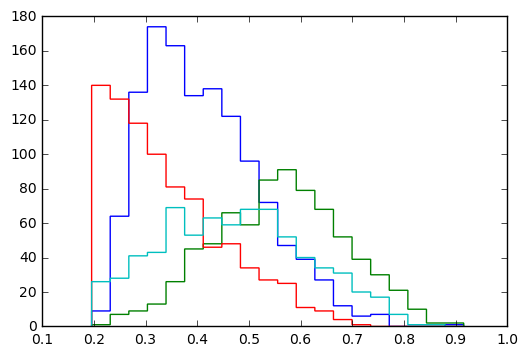

In [142]:
_, b, _ = plt.hist(np.array(pixelated_tau21)[real_labels[:2000] == 1], bins=20, histtype='step')
_ = plt.hist(np.array(pixelated_tau21)[real_labels[:2000] == 0], bins=b, histtype='step')
_ = plt.hist(np.array(real_jets['tau_21'][:2000])[real_labels[:2000] == 1], bins=b, histtype='step')
_ = plt.hist(np.array(real_jets['tau_21'][:2000])[real_labels[:2000] == 0], bins=b, histtype='step')

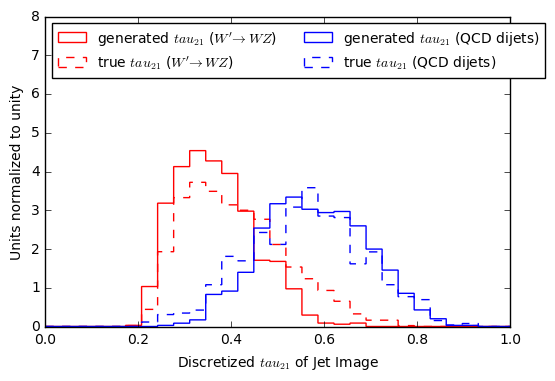

In [157]:
# plot the tau21 of the GAN vs the Pythia Jets
bins = np.linspace(0, 1, 30)
_ = plt.hist(np.array(pixelated_tau21_gan)[sampled_labels[:2000] ==1], 
             bins=bins, histtype='step', label=r"generated $tau_{21}$ ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(np.array(pixelated_tau21)[real_labels[:2000] ==1], 
             bins=bins, histtype='step', label=r"true $tau_{21}$ ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(np.array(pixelated_tau21_gan)[sampled_labels[:2000] == 0], 
             bins=bins, histtype='step', label=r'generated $tau_{21}$ (QCD dijets)', normed=True, color='blue')
_ = plt.hist(np.array(pixelated_tau21)[real_labels[:2000] == 0], 
             bins=bins, histtype='step', label=r'true $tau_{21}$ (QCD dijets)', normed=True, color='blue', linestyle='dashed')
plt.xlabel(r'Discretized $tau_{21}$ of Jet Image')
plt.ylabel(r'Units normalized to unity')
plt.legend(loc=2, prop={'size':10}, ncol=2)
plt.ylim(0, 8)
plt.show()

# Figure 9 equivalent

In [191]:
first_conv_layer = d.layers[3].layers[0]

In [208]:
W, _ = first_conv_layer.get_weights() # returns W, bias

In [272]:
np.squeeze(W)[:, :, 0].shape

(3, 3)

In [275]:
np.squeeze(W)[:, :, i]

array([[-0.00766614, -0.1672173 , -0.00145354],
       [-0.01364721,  0.22767246,  0.19537634],
       [ 0.06173033,  0.30609369, -0.43269137]], dtype=float32)

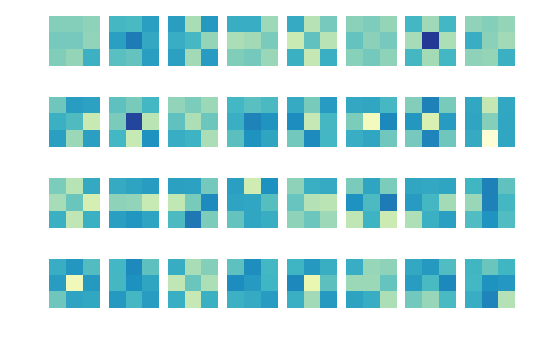

In [292]:
f, axarr = plt.subplots(4, 8)
plt.set_cmap('YlGnBu')
for i in range(W.shape[-1]):
    im = axarr[i/8, i%8].imshow(np.squeeze(W)[:, :, i], interpolation='nearest', norm=Normalize(vmin=-1, vmax=1))
    axarr[i/8, i%8].axis('off')
# plt.colorbar(im)

In [299]:
from scipy.signal import convolve2d

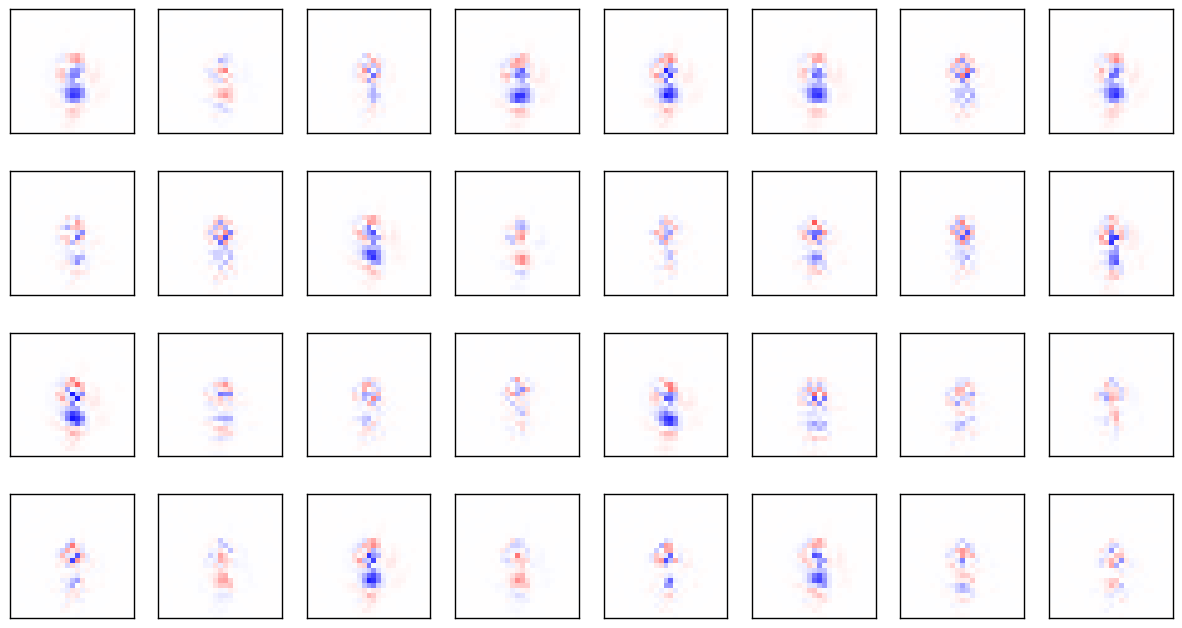

In [364]:
# pythia vs gan activation of each filter 
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
plt.set_cmap('bwr')
for i in range(W.shape[-1]):
    im = axarr[i/8, i%8].imshow(
        convolve2d(
            real_images.mean(axis=0) - np.squeeze(generated_images.mean(axis=0)),
            np.squeeze(W)[:, :, i],
            mode='same'
        ),
        interpolation='nearest', norm=Normalize(vmin=-3, vmax=3)
    )
    axarr[i/8, i%8].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        right='off',
        labelbottom='off',
        labelleft='off')
# plt.colorbar(im)
#convolve2d(np.squeeze(W)[:, :, 0], np.squeeze(generated_images.mean(axis=0)), mode='same')

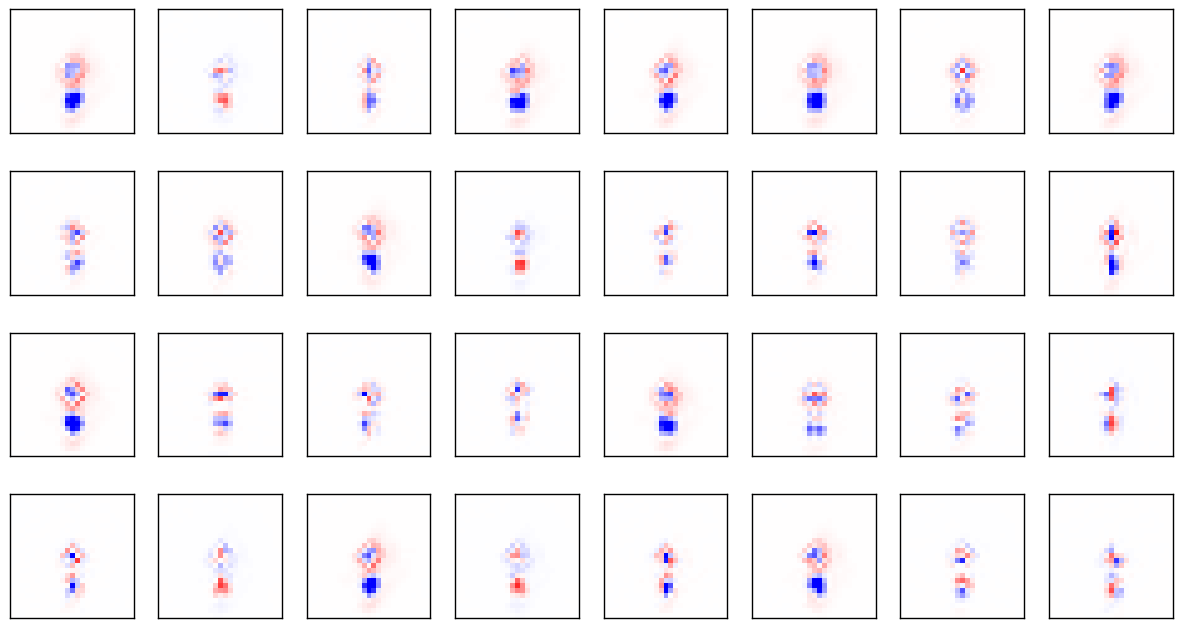

In [360]:
# gan signal vs gan bkg activation of each filter 
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
plt.set_cmap('bwr')
for i in range(W.shape[-1]):
    im = axarr[i/8, i%8].imshow(
        convolve2d(
            np.squeeze(generated_images[sampled_labels == 1].mean(axis=0) - generated_images[sampled_labels == 0].mean(axis=0)),
            np.squeeze(W)[:, :, i],
            mode='same'
        ),
        interpolation='nearest', norm=Normalize(vmin=-10, vmax=10)
    )
    axarr[i/8, i%8].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        right='off',
        labelbottom='off',
        labelleft='off')
# plt.colorbar(im)
#convolve2d(np.squeeze(W)[:, :, 0], np.squeeze(generated_images.mean(axis=0)), mode='same')

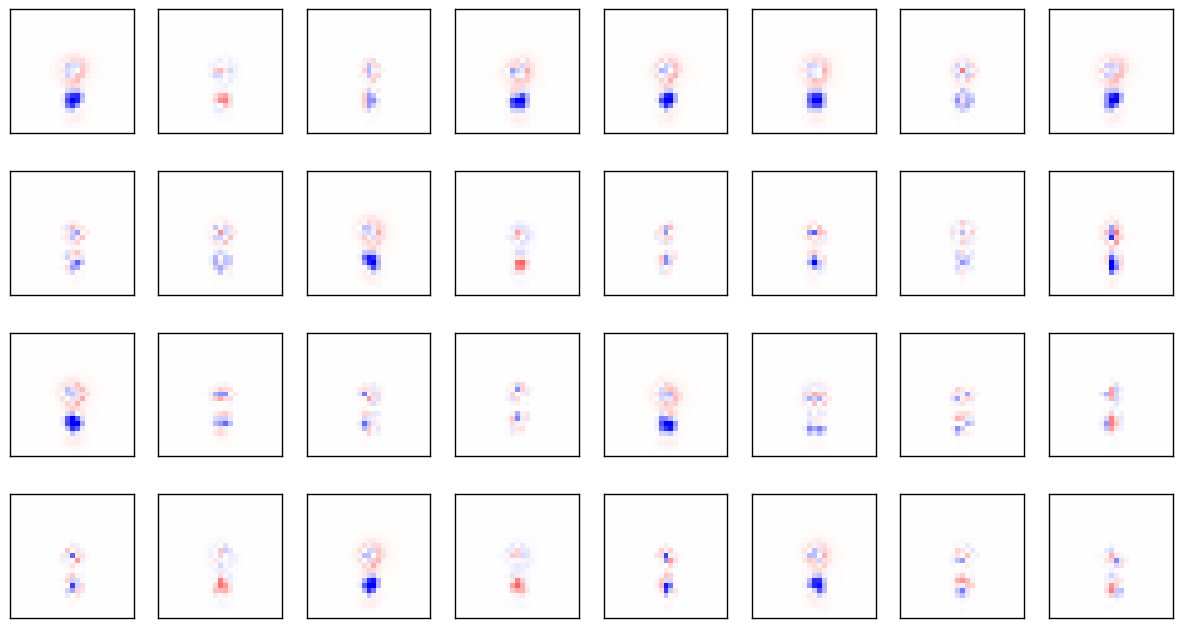

In [366]:
# pythia signal vs pythia bkg activation of each filter 
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
plt.set_cmap('bwr')
for i in range(W.shape[-1]):
    im = axarr[i/8, i%8].imshow(
        convolve2d(
            real_images[real_labels == 1].mean(axis=0) - real_images[real_labels == 0].mean(axis=0),
            np.squeeze(W)[:, :, i],
            mode='same'
        ),
        interpolation='nearest', norm=Normalize(vmin=-10, vmax=10)
    )
    axarr[i/8, i%8].tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        right='off',
        labelbottom='off',
        labelleft='off')
# plt.colorbar(im)
#convolve2d(np.squeeze(W)[:, :, 0], np.squeeze(generated_images.mean(axis=0)), mode='same')

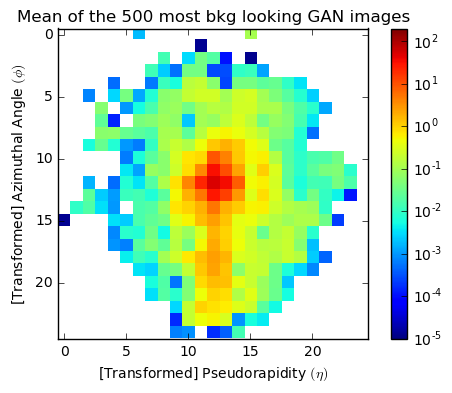

In [397]:
# plot the mean of the 500 gan images with the lowest aux_out
plt.set_cmap('jet')
plt.imshow(np.squeeze(generated_images[np.argsort(aux_out.reshape(-1,))[:500]].mean(axis=0)),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Mean of the 500 most bkg looking GAN images')

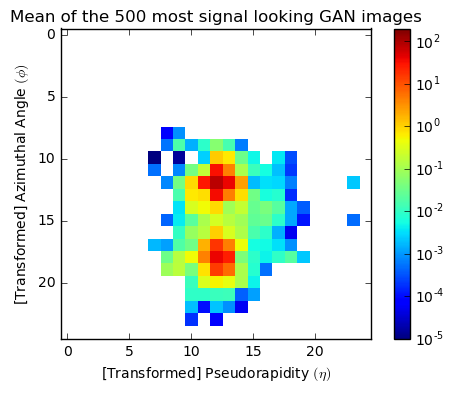

In [398]:
# plot the mean of the 500 gan images with the highest aux_out
plt.set_cmap('jet')
plt.imshow(np.squeeze(generated_images[np.argsort(aux_out.reshape(-1,))[::-1][:500]].mean(axis=0)),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Mean of the 500 most signal looking GAN images')

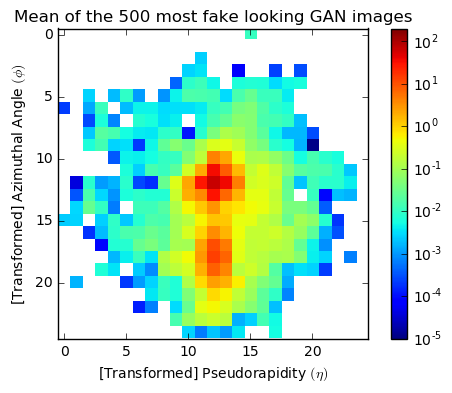

In [399]:
# plot the mean of the 500 gan images with the lowest isreal
plt.set_cmap('jet')
plt.imshow(np.squeeze(generated_images[np.argsort(isreal.reshape(-1,))[:500]].mean(axis=0)),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Mean of the 500 most fake looking GAN images')

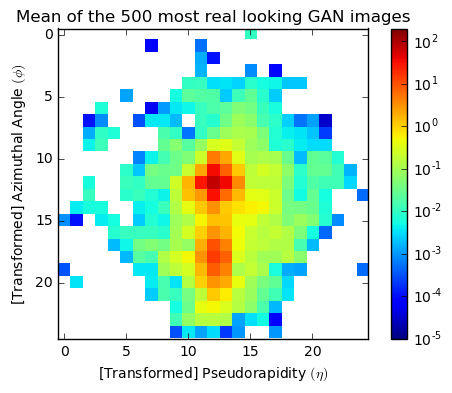

In [400]:
# plot the mean of the 500 gan images with the highest isreal
plt.set_cmap('jet')
plt.imshow(np.squeeze(generated_images[np.argsort(isreal.reshape(-1,))[::-1][:500]].mean(axis=0)),
           interpolation='nearest', norm=LogNorm(vmin=0.00001, vmax=200))
plt.colorbar()
plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
plt.title('Mean of the 500 most real looking GAN images')

In [401]:
from sklearn.metrics import confusion_matrix

[[24558   538]
 [   40 24864]]


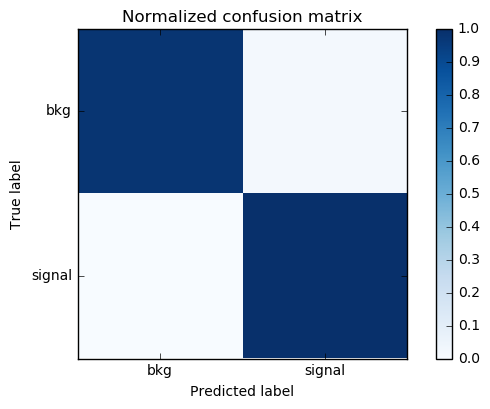

In [413]:
# for GAN images
def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['bkg', 'signal'])
    plt.yticks(tick_marks, ['bkg', 'signal'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(sampled_labels, (aux_out > 0.5))
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
print cm

[[15019  3570]
 [ 5981 25430]]


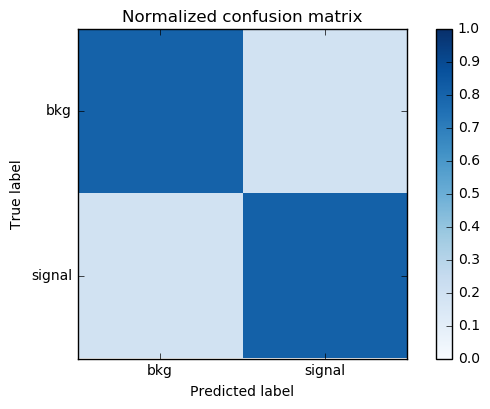

In [414]:
# for pythia images
def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['bkg', 'signal'])
    plt.yticks(tick_marks, ['bkg', 'signal'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(real_labels, (aux_out_pythia > 0.5))
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
print cm

[[17497  7599]
 [17556  7348]]


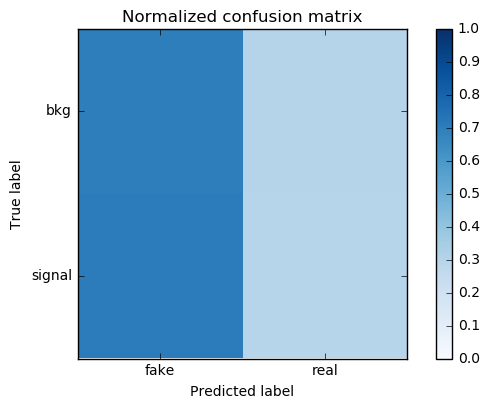

In [415]:
# for GAN images
def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['fake', 'real'])
    plt.yticks(tick_marks, ['bkg', 'signal'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(sampled_labels, (isreal > 0.5))
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
print cm

[[ 6053 12536]
 [ 5122 26289]]


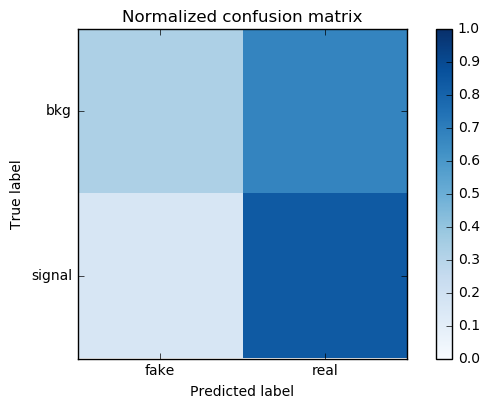

In [416]:
# for pythia images
def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['fake', 'real'])
    plt.yticks(tick_marks, ['bkg', 'signal'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(real_labels, (isreal_pythia > 0.5))
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
print cm

In [ ]:
# correlation between the pixels of a GAN image and the output of the D that tells us if an image looks more like signal or bkg
df = pd.DataFrame({i : np.squeeze(generated_images).reshape(-1, 625)[:, i] for i in range(625)})
df['aux_out'] = aux_out
corr_w_aux_out = df.corr().values[:-1, -1]
max_mag = max(
    abs(np.min(corr_w_aux_out[np.isfinite(corr_w_aux_out)])),
    abs(np.max(corr_w_aux_out[np.isfinite(corr_w_aux_out)])),
)

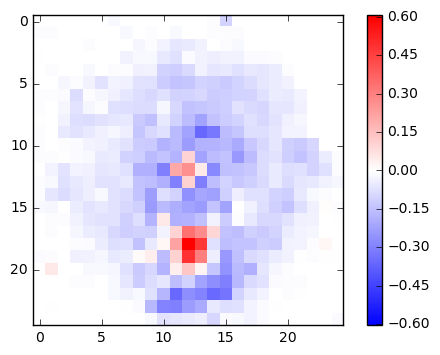

In [525]:
plt.set_cmap('bwr')
plt.imshow(corr_w_aux_out.reshape(25, 25),
           interpolation='nearest',
           norm=Normalize(vmin=-max_mag, vmax=max_mag)
           )
plt.colorbar()

In [534]:
# correlation between the pixels of a signal GAN image and the output of the D that tells us if an image looks more like signal or bkg
corr_w_aux_out_signal = df[sampled_labels == 1].corr().values[:-1, -1]
max_mag_signal = max(
    abs(np.min(corr_w_aux_out_signal[np.isfinite(corr_w_aux_out_signal)])),
    abs(np.max(corr_w_aux_out_signal[np.isfinite(corr_w_aux_out_signal)])),
)

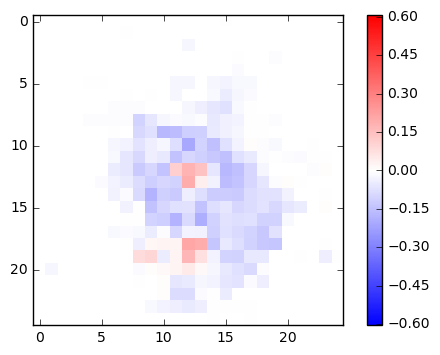

In [536]:
plt.imshow(corr_w_aux_out_signal.reshape(25, 25),
           interpolation='nearest',
           norm=Normalize(vmin=-max_mag, vmax=max_mag)
           )
plt.colorbar()

In [538]:
# correlation between the pixels of a bkg GAN image and the output of the D that tells us if an image looks more like signal or bkg
corr_w_aux_out_bkg = df[sampled_labels == 0].corr().values[:-1, -1]
max_mag_bkg = max(
    abs(np.min(corr_w_aux_out_bkg[np.isfinite(corr_w_aux_out_bkg)])),
    abs(np.max(corr_w_aux_out_bkg[np.isfinite(corr_w_aux_out_bkg)])),
)

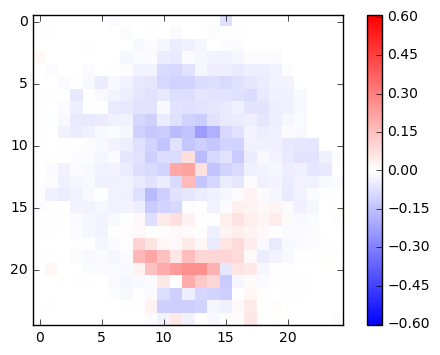

In [539]:
plt.imshow(corr_w_aux_out_bkg.reshape(25, 25),
           interpolation='nearest',
           norm=Normalize(vmin=-max_mag, vmax=max_mag)
           )
plt.colorbar()

In [543]:
# correlation between the pixels of a GAN image and the output of the D that tells us if an image looks real or fake
df2 = pd.DataFrame({i : np.squeeze(generated_images).reshape(-1, 625)[:, i] for i in range(625)})
df2['isreal'] = isreal
corr_w_isreal = df2.corr().values[:-1, -1]
max_mag2 = max(
    abs(np.min(corr_w_isreal[np.isfinite(corr_w_isreal)])),
    abs(np.max(corr_w_isreal[np.isfinite(corr_w_isreal)])),
)

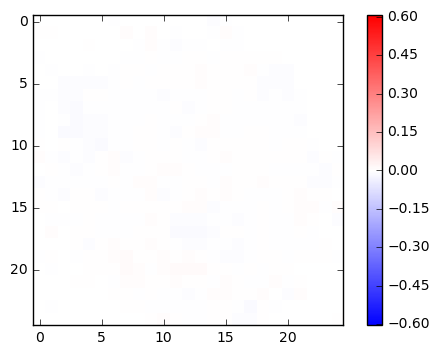

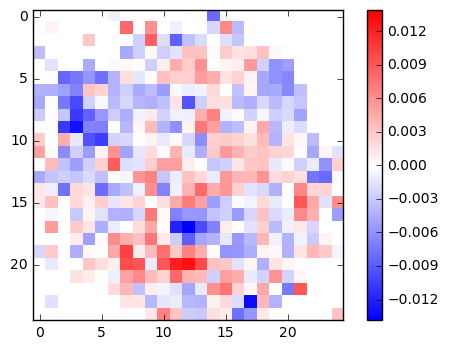

In [542]:
plt.imshow(corr_w_isreal.reshape(25, 25),
           interpolation='nearest', norm=Normalize(vmin=-max_mag, vmax=max_mag)) # can plot on same scale as above
plt.colorbar()
plt.show()

plt.imshow(corr_w_isreal.reshape(25, 25),
           interpolation='nearest', norm=Normalize(vmin=-max_mag2, vmax=max_mag2)) # or on new scale
plt.colorbar()
plt.show()

In [544]:
# correlation between the pixels of a signal GAN image and the output of the D that tells us if an image looks more real or fake
corr_w_isreal_signal = df2[sampled_labels == 1].corr().values[:-1, -1]
max_mag2_signal = max(
    abs(np.min(corr_w_isreal_signal[np.isfinite(corr_w_isreal_signal)])),
    abs(np.max(corr_w_isreal_signal[np.isfinite(corr_w_isreal_signal)])),
)

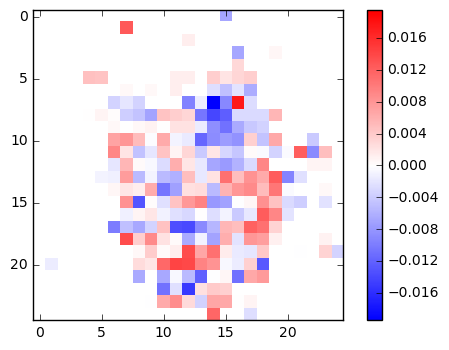

In [546]:
plt.imshow(corr_w_isreal_signal.reshape(25, 25),
           interpolation='nearest',
           norm=Normalize(vmin=-max_mag2_signal, vmax=max_mag2_signal)
           )
plt.colorbar()

In [547]:
# correlation between the pixels of a bkg GAN image and the output of the D that tells us if an image looks more real or fake
corr_w_isreal_bkg = df2[sampled_labels == 0].corr().values[:-1, -1]
max_mag2_bkg = max(
    abs(np.min(corr_w_isreal_bkg[np.isfinite(corr_w_isreal_bkg)])),
    abs(np.max(corr_w_isreal_bkg[np.isfinite(corr_w_isreal_bkg)])),
)

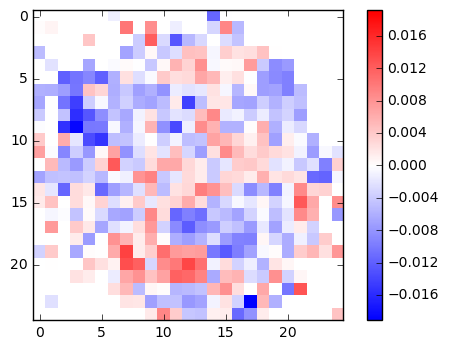

In [548]:
plt.imshow(corr_w_isreal_bkg.reshape(25, 25),
           interpolation='nearest',
           norm=Normalize(vmin=-max_mag2_bkg, vmax=max_mag2_bkg)
           )
plt.colorbar()

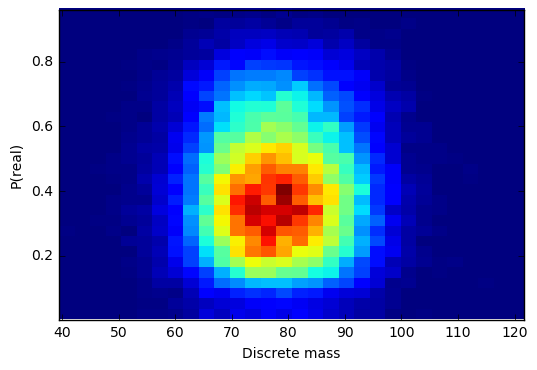

In [561]:
plt.set_cmap('jet')
_ = plt.hist2d(discrete_mass(np.squeeze(generated_images)), isreal, bins=30)
plt.xlabel('Discrete mass')
plt.ylabel('P(real)')

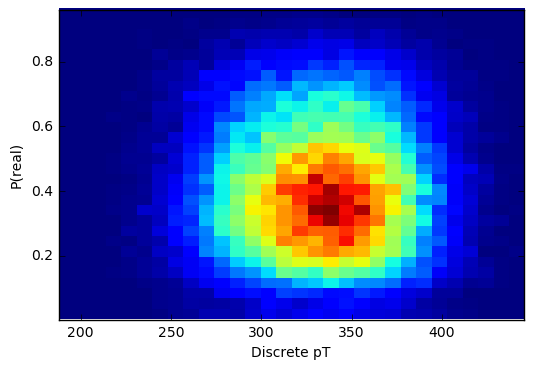

In [567]:
plt.set_cmap('jet')
_ = plt.hist2d(discrete_pt(np.squeeze(generated_images)), isreal, bins=30)
plt.xlabel('Discrete pT')
plt.ylabel('P(real)')

In [570]:
pixelated_tau21_gan =  np.array([tau21(img) for img in tqdm(np.squeeze(generated_images))])

 30%|███       | 15109/50000 [08:34<14:41, 39.57it/s]

KeyboardInterrupt: 

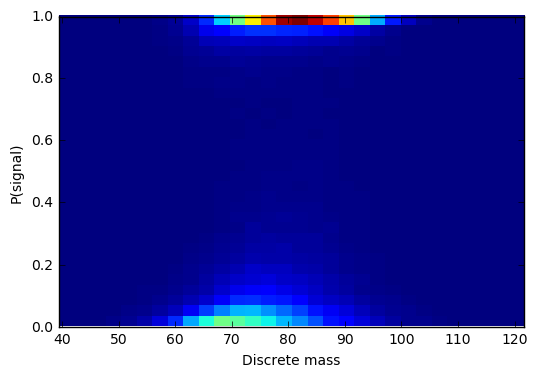

In [565]:
plt.set_cmap('jet')
_ = plt.hist2d(discrete_mass(np.squeeze(generated_images)), aux_out, bins=30)
plt.xlabel('Discrete mass')
plt.ylabel('P(signal)')

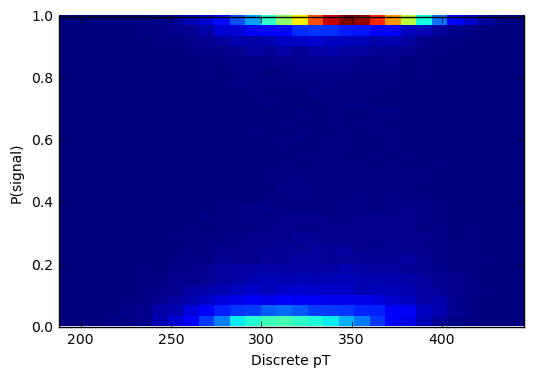

In [568]:
plt.set_cmap('jet')
_ = plt.hist2d(discrete_pt(np.squeeze(generated_images)), aux_out, bins=30)
plt.xlabel('Discrete pT')
plt.ylabel('P(signal)')